# Análise de Setores Censitários para Previsão de Demanda APS

Este notebook analisa dados de setores censitários para desenvolver um modelo preditivo de demanda por serviços de Atenção Primária à Saúde, baseado em determinantes sociais da saúde.

**Escopo:** 4 municípios de MG (Belo Horizonte, Contagem, Divinópolis, Lagoa Santa)

**Nota:** Bela Vista de Minas e Sete Lagoas não estão com os cálculos disponíveis na base de dados agregada dos setores censitários


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


## Carregamento dos Dados


In [2]:
# Carregar dados dos setores censitários
df_setores = pd.read_excel("../data/raw/Cidades-APS.xlsx")
print(f"Dados dos setores: {df_setores.shape}")
df_setores.head()


Dados dos setores: (5622, 7)


,MUNICIPIO,SETOR,Capital Humano,Infra Urbana,Vulnerab. Saúde,Índice,Coordenadas
0,Belo Horizonte,310620005620001,0.206642,0.0,0.812975,0.509808,"(-19.93731685089084, -43.926580111579426)"
1,Belo Horizonte,310620005620002,0.196556,0.0,0.812975,0.504766,"(-19.935326301339895, -43.92741213249793)"
2,Belo Horizonte,310620005620004,0.224226,0.0,0.812975,0.518601,"(-19.93367596419928, -43.922337677945244)"
3,Belo Horizonte,310620005620005,0.214315,0.0,0.812975,0.513645,"(-19.935689542100356, -43.92387245806792)"
4,Belo Horizonte,310620005620006,0.245152,0.0,0.812975,0.529064,"(-19.93719645845511, -43.92505553377516)"


In [3]:
# Verificar estrutura dos dados
print("Colunas disponíveis:")
print(df_setores.columns.tolist())
print(f"\nMunicípios únicos: {df_setores['MUNICIPIO'].nunique()}")
print(f"Setores únicos: {df_setores['SETOR'].nunique()}")


Colunas disponíveis:
['MUNICIPIO', 'SETOR', 'Capital Humano', 'Infra Urbana', 'Vulnerab. Saúde', 'Índice', 'Coordenadas']

Municípios únicos: 5
Setores únicos: 5622


In [4]:
# Verificar municípios disponíveis
print("Municípios na base:")
print(df_setores['MUNICIPIO'].value_counts().sort_index())


Municípios na base:
MUNICIPIO
Belo Horizonte    3218
Contagem           853
Divinópolis        508
Lagoa Santa        224
Montes Claros      819
Name: count, dtype: int64


In [5]:
# Carregar indicadores Previne Brasil - VPB01 (Gestantes com 6+ consultas pré-natal)
gestantes_prenatal = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                                  sheet_name="Dados")
print(f"Gestantes pré-natal: {gestantes_prenatal.shape}")
print("Primeiras linhas:")
gestantes_prenatal.head()


Gestantes pré-natal: (22, 13)
Primeiras linhas:


,Ministério da Saúde MS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Secretaria de Atenção Primária à Saúde SAPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Painel Indicador,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Estratégia eSUS- AB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Unidade Geográfica: Munícipio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Estado: MG.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Verificar onde começam os dados reais (linha 13)
print("Dados da linha 13 (cabeçalho):")
print(gestantes_prenatal.iloc[12].tolist())
print("\nDados da linha 14 (primeira linha de dados):")
print(gestantes_prenatal.iloc[13].tolist())


Dados da linha 13 (cabeçalho):
['MG', '310600', 'BELA VISTA DE MINAS', '23', '30', '30', '40', '81', '37', '88', '63', '47', '42']

Dados da linha 14 (primeira linha de dados):
['MG', '310620', 'BELO HORIZONTE', '24', '21', '22', '26', '27', '25', '23', '18', '10', '13']


In [11]:
# Extrair dados corretos (linha 12 = cabeçalho, linha 13+ = dados)
gestantes_clean = gestantes_prenatal.iloc[11:48].copy()  # linha 12 em diante
gestantes_clean.columns = gestantes_clean.iloc[0].values  # linha 12 como cabeçalho
gestantes_clean = gestantes_clean.iloc[1:].reset_index(drop=True)  # remover linha do cabeçalho

print(f"Gestantes pré-natal limpo: {gestantes_clean.shape}")
print("Colunas:")
print(gestantes_clean.columns.tolist())
gestantes_clean.head()


Gestantes pré-natal limpo: (10, 13)
Colunas:
['UF', 'IBGE', 'Munícipio', '2022 Q1 (%)', '2022 Q2 (%)', '2022 Q3 (%)', '2023 Q1 (%)', '2023 Q2 (%)', '2023 Q3 (%)', '2024 Q1 (%)', '2024 Q2 (%)', '2024 Q3 (%)', '2025 Q1 (%)']


,UF,IBGE,Munícipio,2022 Q1 (%),2022 Q2 (%),2022 Q3 (%),2023 Q1 (%),2023 Q2 (%),2023 Q3 (%),2024 Q1 (%),2024 Q2 (%),2024 Q3 (%),2025 Q1 (%)
0,MG,310600,BELA VISTA DE MINAS,23,30,30,40,81,37,88,63,47,42
1,MG,310620,BELO HORIZONTE,24,21,22,26,27,25,23,18,10,13
2,MG,311860,CONTAGEM,14,15,19,26,33,34,36,35,27,39
3,MG,313760,LAGOA SANTA,37,39,36,34,41,36,42,39,27,45
4,MG,312230,DIVINÓPOLIS,41,41,33,39,53,44,44,41,38,51


In [14]:
# Carregar os demais indicadores Previne Brasil
indicadores_previne = {}

# VPB01 - Gestantes com 6+ consultas pré-natal (já carregado)
indicadores_previne['gestantes_prenatal'] = gestantes_clean

# VPB02 - Gestantes com exames sífilis/HIV
gestantes_exames = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                                sheet_name="Página1")
gestantes_exames_clean = gestantes_exames.iloc[11:48].copy()  # linha 12 em diante
gestantes_exames_clean.columns = gestantes_exames_clean.iloc[0].values  # linha 12 como cabeçalho
gestantes_exames_clean = gestantes_exames_clean.iloc[1:].reset_index(drop=True)
indicadores_previne['gestantes_exames'] = gestantes_exames_clean

# VPB03 - Gestantes com atendimento odontológico
gestantes_odonto = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                                sheet_name="Página2")
gestantes_odonto_clean = gestantes_odonto.iloc[11:48].copy()  # linha 12 em diante
gestantes_odonto_clean.columns = gestantes_odonto_clean.iloc[0].values  # linha 12 como cabeçalho
gestantes_odonto_clean = gestantes_odonto_clean.iloc[1:].reset_index(drop=True)
indicadores_previne['gestantes_odonto'] = gestantes_odonto_clean

print("Indicadores carregados:")
for nome, df in indicadores_previne.items():
    print(f"  {nome}: {df.shape}")


Indicadores carregados:
  gestantes_prenatal: (10, 13)
  gestantes_exames: (10, 13)
  gestantes_odonto: (10, 13)


In [15]:
# Carregar os demais indicadores
# VPB04 - Mulheres com coleta citopatológico
mulheres_citopatologico = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                                       sheet_name="Página3")
mulheres_citopatologico_clean = mulheres_citopatologico.iloc[11:48].copy()  # linha 12 em diante
mulheres_citopatologico_clean.columns = mulheres_citopatologico_clean.iloc[0].values  # linha 12 como cabeçalho
mulheres_citopatologico_clean = mulheres_citopatologico_clean.iloc[1:].reset_index(drop=True)
indicadores_previne['mulheres_citopatologico'] = mulheres_citopatologico_clean

# VPB05 - Crianças 1 ano vacinadas contra poliomielite
criancas_vacina = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                               sheet_name="Página4")
criancas_vacina_clean = criancas_vacina.iloc[11:48].copy()  # linha 12 em diante
criancas_vacina_clean.columns = criancas_vacina_clean.iloc[0].values  # linha 12 como cabeçalho
criancas_vacina_clean = criancas_vacina_clean.iloc[1:].reset_index(drop=True)
indicadores_previne['criancas_vacina'] = criancas_vacina_clean

# VPB06 - Hipertensos com pressão arterial aferida
hipertensos_pressao = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                                   sheet_name="Página5")
hipertensos_pressao_clean = hipertensos_pressao.iloc[11:48].copy()  # linha 12 em diante
hipertensos_pressao_clean.columns = hipertensos_pressao_clean.iloc[0].values  # linha 12 como cabeçalho
hipertensos_pressao_clean = hipertensos_pressao_clean.iloc[1:].reset_index(drop=True)
indicadores_previne['hipertensos_pressao'] = hipertensos_pressao_clean

# VPB07 - Diabéticos com hemoglobina glicada solicitada
diabeticos_hemoglobina = pd.read_excel("../data/raw/Indicadores principais da APS do Programa Previne Brasil.xlsx", 
                                      sheet_name="Página6")
diabeticos_hemoglobina_clean = diabeticos_hemoglobina.iloc[11:48].copy()  # linha 12 em diante
diabeticos_hemoglobina_clean.columns = diabeticos_hemoglobina_clean.iloc[0].values  # linha 12 como cabeçalho
diabeticos_hemoglobina_clean = diabeticos_hemoglobina_clean.iloc[1:].reset_index(drop=True)
indicadores_previne['diabeticos_hemoglobina'] = diabeticos_hemoglobina_clean

print("Todos os indicadores carregados:")
for nome, df in indicadores_previne.items():
    print(f"  {nome}: {df.shape}")


Todos os indicadores carregados:
  gestantes_prenatal: (10, 13)
  gestantes_exames: (10, 13)
  gestantes_odonto: (10, 13)
  mulheres_citopatologico: (10, 13)
  criancas_vacina: (10, 13)
  hipertensos_pressao: (10, 13)
  diabeticos_hemoglobina: (10, 13)


## Consolidação dos Indicadores Previne


In [16]:
# Consolidar todos os indicadores em um DataFrame
df_previne = indicadores_previne['gestantes_prenatal'].copy()
df_previne = df_previne[['UF', 'IBGE', 'Munícipio'] + [col for col in df_previne.columns if 'Q' in col]].copy()

# Renomear colunas do VPB01
for col in df_previne.columns:
    if 'Q' in col:
        df_previne = df_previne.rename(columns={col: f'VPB01_{col}'})

print(f"DataFrame base: {df_previne.shape}")
print("Colunas:")
print(df_previne.columns.tolist())
df_previne.head()


DataFrame base: (10, 13)
Colunas:
['UF', 'IBGE', 'Munícipio', 'VPB01_2022 Q1 (%)', 'VPB01_2022 Q2 (%)', 'VPB01_2022 Q3 (%)', 'VPB01_2023 Q1 (%)', 'VPB01_2023 Q2 (%)', 'VPB01_2023 Q3 (%)', 'VPB01_2024 Q1 (%)', 'VPB01_2024 Q2 (%)', 'VPB01_2024 Q3 (%)', 'VPB01_2025 Q1 (%)']


,UF,IBGE,Munícipio,VPB01_2022 Q1 (%),VPB01_2022 Q2 (%),VPB01_2022 Q3 (%),VPB01_2023 Q1 (%),VPB01_2023 Q2 (%),VPB01_2023 Q3 (%),VPB01_2024 Q1 (%),VPB01_2024 Q2 (%),VPB01_2024 Q3 (%),VPB01_2025 Q1 (%)
0,MG,310600,BELA VISTA DE MINAS,23,30,30,40,81,37,88,63,47,42
1,MG,310620,BELO HORIZONTE,24,21,22,26,27,25,23,18,10,13
2,MG,311860,CONTAGEM,14,15,19,26,33,34,36,35,27,39
3,MG,313760,LAGOA SANTA,37,39,36,34,41,36,42,39,27,45
4,MG,312230,DIVINÓPOLIS,41,41,33,39,53,44,44,41,38,51


In [17]:
# Adicionar os demais indicadores
for nome, df in indicadores_previne.items():
    if nome != 'gestantes_prenatal':
        vpb_num = nome.split('_')[0].upper().replace('GESTANTES', 'VPB01').replace('MULHERES', 'VPB04').replace('CRIANCAS', 'VPB05').replace('HIPERTENSOS', 'VPB06').replace('DIABETICOS', 'VPB07')
        if 'exames' in nome:
            vpb_num = 'VPB02'
        elif 'odonto' in nome:
            vpb_num = 'VPB03'
        
        colunas_trimestres = [col for col in df.columns if 'Q' in col]
        
        for col in colunas_trimestres:
            df_previne[f'{vpb_num}_{col}'] = df[col].values

print(f"DataFrame consolidado: {df_previne.shape}")
print("Colunas dos indicadores:")
colunas_indicadores = [col for col in df_previne.columns if 'VPB' in col]
print(f"Total: {len(colunas_indicadores)} colunas")
print(colunas_indicadores[:10])  # primeiras 10


DataFrame consolidado: (10, 73)
Colunas dos indicadores:
Total: 70 colunas
['VPB01_2022 Q1 (%)', 'VPB01_2022 Q2 (%)', 'VPB01_2022 Q3 (%)', 'VPB01_2023 Q1 (%)', 'VPB01_2023 Q2 (%)', 'VPB01_2023 Q3 (%)', 'VPB01_2024 Q1 (%)', 'VPB01_2024 Q2 (%)', 'VPB01_2024 Q3 (%)', 'VPB01_2025 Q1 (%)']


In [18]:
# Verificar municípios no Previne
print("Municípios no Previne Brasil:")
print(df_previne['Munícipio'].unique())
print(f"\nTotal: {df_previne['Munícipio'].nunique()} municípios")

# Verificar se há Lagoa Santa (que não está nos setores censitários)
if 'LAGOA SANTA' in df_previne['Munícipio'].values:
    print("\nLAGOA SANTA encontrado no Previne Brasil!")
else:
    print("\nLAGOA SANTA não encontrado no Previne Brasil")


Municípios no Previne Brasil:
['BELA VISTA DE MINAS' 'BELO HORIZONTE' 'CONTAGEM' 'LAGOA SANTA'
 'DIVINÓPOLIS' 'SETE LAGOAS' nan]

Total: 6 municípios

LAGOA SANTA encontrado no Previne Brasil!


## Aplicação da Inversão dos Indicadores


In [20]:
# Aplicar inversão: 1 - (valor/100)
print("Aplicando inversão dos indicadores...")
print("Fórmula: 1 - (valor/100)")

# Identificar colunas dos indicadores
colunas_previne = [col for col in df_previne.columns if 'VPB' in col and 'Q' in col]
print(f"Colunas para inversão: {len(colunas_previne)}")

# Aplicar inversão
for col in colunas_previne:
    # Converter para numérico, substituindo valores não numéricos por NaN
    df_previne[col] = pd.to_numeric(df_previne[col], errors='coerce')
    df_previne[col] = df_previne[col].fillna(0)
    df_previne[col] = 1 - (df_previne[col] / 100)
    df_previne = df_previne.rename(columns={col: f'{col}_INV'})

print("Inversão aplicada!")
print(f"Exemplo de valores após inversão:")
exemplo_cols = [col for col in df_previne.columns if 'VPB01' in col and 'INV' in col]
df_previne[['Munícipio'] + exemplo_cols].head()


Aplicando inversão dos indicadores...
Fórmula: 1 - (valor/100)
Colunas para inversão: 70
Inversão aplicada!
Exemplo de valores após inversão:


,Munícipio,VPB01_2022 Q1 (%)_INV,VPB01_2022 Q2 (%)_INV,VPB01_2022 Q3 (%)_INV,VPB01_2023 Q1 (%)_INV,VPB01_2023 Q2 (%)_INV,VPB01_2023 Q3 (%)_INV,VPB01_2024 Q1 (%)_INV,VPB01_2024 Q2 (%)_INV,VPB01_2024 Q3 (%)_INV,VPB01_2025 Q1 (%)_INV
0,BELA VISTA DE MINAS,0.77,0.70,0.70,0.60,0.19,0.63,0.12,0.37,0.53,0.58
1,BELO HORIZONTE,0.76,0.79,0.78,0.74,0.73,0.75,0.77,0.82,0.90,0.87
2,CONTAGEM,0.86,0.85,0.81,0.74,0.67,0.66,0.64,0.65,0.73,0.61
3,LAGOA SANTA,0.63,0.61,0.64,0.66,0.59,0.64,0.58,0.61,0.73,0.55
4,DIVINÓPOLIS,0.59,0.59,0.67,0.61,0.47,0.56,0.56,0.59,0.62,0.49


## Integração dos Dados

In [23]:
# Verificar correspondência de municípios
print("Municípios nos setores censitários:")
print(sorted(df_setores['MUNICIPIO'].unique()))
print("\nMunicípios no Previne Brasil:")
print(sorted(df_previne['Munícipio'].dropna().unique()))

# Padronizar nomes dos municípios para comparação
df_setores['MUNICIPIO_PADRONIZADO'] = df_setores['MUNICIPIO'].str.upper()
df_previne['MUNICIPIO_PADRONIZADO'] = df_previne['Munícipio'].str.upper()

# Identificar municípios comuns
municipios_setores = set(df_setores['MUNICIPIO_PADRONIZADO'].unique())
municipios_previne = set(df_previne['MUNICIPIO_PADRONIZADO'].dropna().unique())
municipios_comuns = municipios_setores.intersection(municipios_previne)

print(f"\nMunicípios comuns (padronizados): {len(municipios_comuns)}")
print(sorted(municipios_comuns))


Municípios nos setores censitários:
['Belo Horizonte', 'Contagem', 'Divinópolis', 'Lagoa Santa', 'Montes Claros']

Municípios no Previne Brasil:
['BELA VISTA DE MINAS', 'BELO HORIZONTE', 'CONTAGEM', 'DIVINÓPOLIS', 'LAGOA SANTA', 'SETE LAGOAS']

Municípios comuns (padronizados): 4
['BELO HORIZONTE', 'CONTAGEM', 'DIVINÓPOLIS', 'LAGOA SANTA']


In [28]:
# Integrar dados: atribuir valores municipais do Previne a todos os setores do município
print("Integrando dados...")

# Fazer merge dos dados usando os nomes padronizados
df_integrado = df_setores.merge(df_previne, left_on='MUNICIPIO_PADRONIZADO', right_on='MUNICIPIO_PADRONIZADO', how='left')

print(f"Dados integrados: {df_integrado.shape}")

# Verificar se a integração foi bem-sucedida
colunas_previne_inv = [col for col in df_integrado.columns if 'VPB' in col and 'INV' in col]
print(f"\nIndicadores Previne integrados: {len(colunas_previne_inv)}")

# Verificar valores nulos por tipo de coluna
print(f"\nAnálise de valores nulos:")
print(f"- Colunas dos setores censitários: {df_integrado[['MUNICIPIO', 'SETOR', 'Capital Humano', 'Infra Urbana', 'Vulnerab. Saúde', 'Índice']].isnull().sum().sum()}")
print(f"- Colunas do Previne Brasil: {df_integrado[colunas_previne_inv].isnull().sum().sum()}")
print(f"- Total de valores nulos: {df_integrado.isnull().sum().sum()}")

# Verificar quantos setores têm dados do Previne
setores_com_previne = df_integrado[colunas_previne_inv].notna().any(axis=1).sum()
print(f"\nSetores com dados do Previne: {setores_com_previne} de {len(df_integrado)}")


Integrando dados...
Dados integrados: (5622, 81)

Indicadores Previne integrados: 70

Análise de valores nulos:
- Colunas dos setores censitários: 0
- Colunas do Previne Brasil: 57330
- Total de valores nulos: 59787

Setores com dados do Previne: 4803 de 5622


## Resumo da Integração

### Dados integrados:
- 5,622 setores censitários
- 4 municípios: Belo Horizonte, Contagem, Divinópolis, Lagoa Santa
- 4 índices dos setores + 70 indicadores Previne Brasil

### Resultado:
- 4.803 setores com dados completos (municípios coincidentes)
- 819 setores de Montes Claros (sem dados Previne)
- Análise focada nos 4.803 setores com dados completos


In [35]:
# Filtrar apenas os municípios coincidentes para análise
df_analise = df_integrado[df_integrado['MUNICIPIO_PADRONIZADO'].isin(municipios_comuns)].copy()

print("=== DADOS PARA ANÁLISE ===")
print(f"Setores para análise: {len(df_analise):,}")
print(f"Municípios: {sorted(df_analise['MUNICIPIO'].unique())}")
print(f"Setores por município:")
for municipio in sorted(df_analise['MUNICIPIO'].unique()):
    n_setores = df_analise[df_analise['MUNICIPIO'] == municipio].shape[0]
    print(f"   - {municipio}: {n_setores:,} setores")


=== DADOS PARA ANÁLISE ===
Setores para análise: 4,803
Municípios: ['Belo Horizonte', 'Contagem', 'Divinópolis', 'Lagoa Santa']
Setores por município:
   - Belo Horizonte: 3,218 setores
   - Contagem: 853 setores
   - Divinópolis: 508 setores
   - Lagoa Santa: 224 setores


## Análise Exploratória dos Dados Integrados


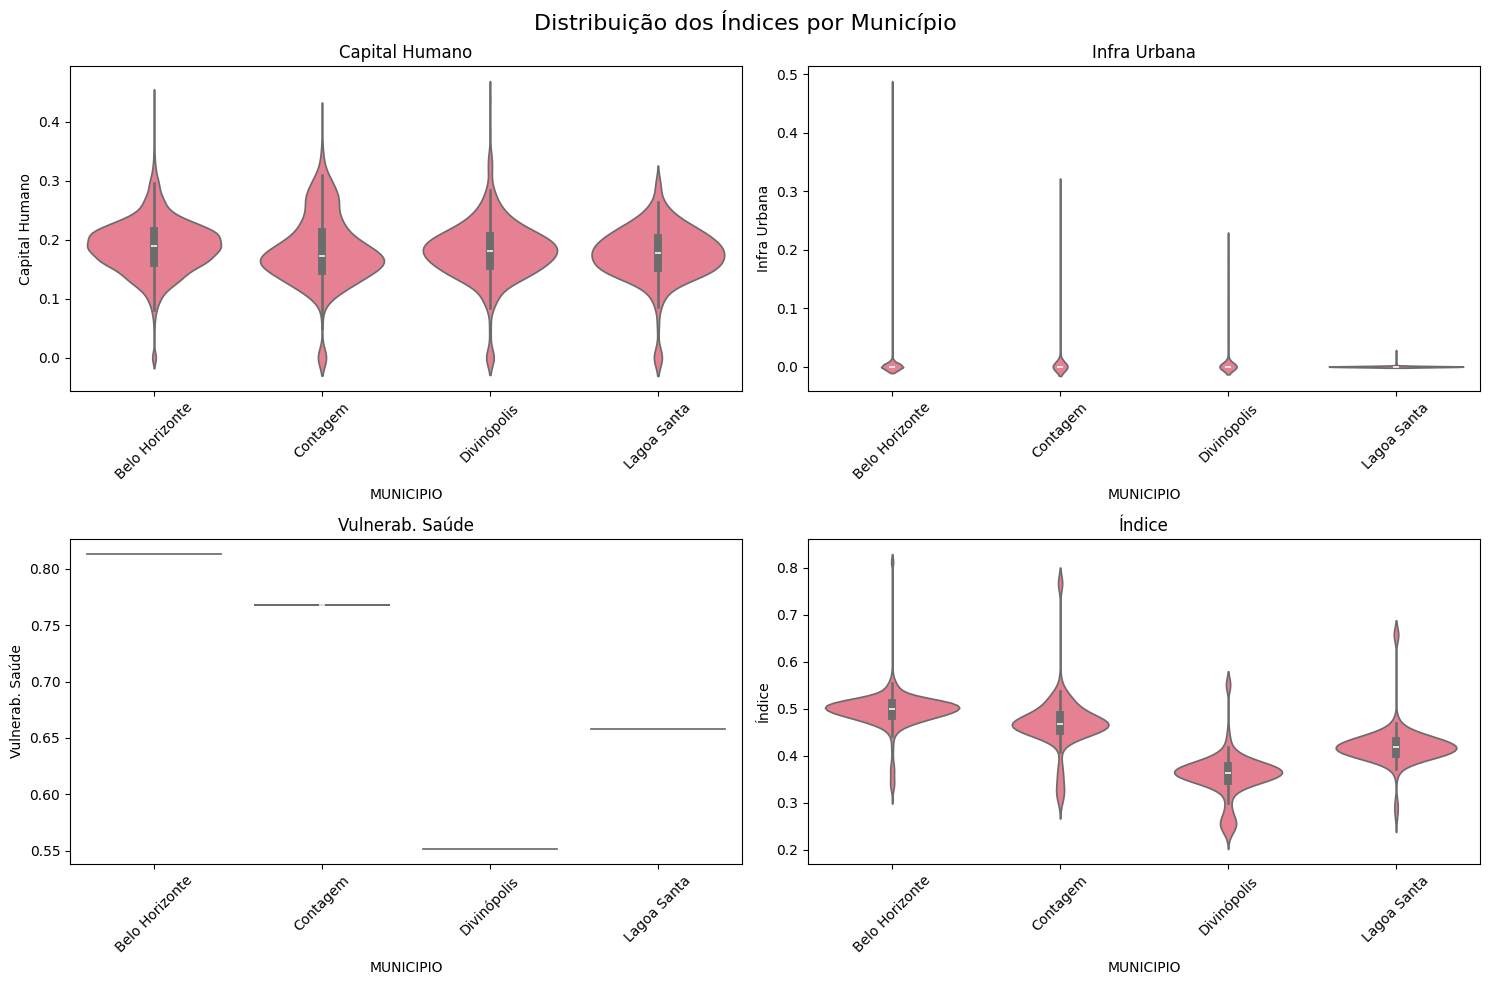

In [41]:
# Visualizar distribuição dos índices com violin plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribuição dos Índices por Município', fontsize=16)

for i, idx in enumerate(indices):
    row = i // 2
    col = i % 2
    
    sns.violinplot(data=df_analise, x='MUNICIPIO', y=idx, ax=axes[row, col])
    axes[row, col].set_title(f'{idx}')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


A análise dos violin plots revela padrões distintos entre os quatro indicadores analisados. O Capital Humano apresenta distribuições similares entre os municípios, com concentração de valores entre 0.15 e 0.25, onde Belo Horizonte e Contagem mostram distribuições ligeiramente mais dispersas, indicando maior variabilidade interna nos setores censitários. A forma simétrica das distribuições sugere que a maioria dos setores possui níveis moderados de capital humano.

A Infraestrutura Urbana apresenta um padrão marcante de concentração extrema em valores próximos a zero, com caudas longas indicando poucos setores com infraestrutura urbana desenvolvida. Belo Horizonte apresenta a maior variabilidade, com alguns setores alcançando valores significativamente mais altos, enquanto Lagoa Santa mostra a menor dispersão, concentrando-se quase exclusivamente em valores muito baixos.

Um aspecto crítico observado é que os dados de vulnerabilidade em saúde apresentam variação mínima entre setores dentro de cada município. Cada município possui um valor praticamente constante para todos os seus setores censitários. As diferenças são significativas entre municípios (Belo Horizonte: 0.81, Divinópolis: 0.55), mas inexistentes internamente.

O índice geral reflete a combinação dos indicadores anteriores, mostrando maior variabilidade que a vulnerabilidade em saúde. Belo Horizonte e Contagem apresentam os valores mais altos e maior dispersão, enquanto Divinópolis concentra-se em valores mais baixos.

In [40]:
# Análise dos índices por município
indices = ['Capital Humano', 'Infra Urbana', 'Vulnerab. Saúde', 'Índice']
print("Médias dos índices por município:")
medias_indices = df_integrado.groupby('MUNICIPIO')[indices].mean().round(3)
display(medias_indices)


Médias dos índices por município:


,Capital Humano,Infra Urbana,Vulnerab. Saúde,Índice
MUNICIPIO,,,,
Belo Horizonte,0.188,0.004,0.813,0.497
Contagem,0.181,0.006,0.768,0.470
Divinópolis,0.180,0.006,0.552,0.359
Lagoa Santa,0.175,0.000,0.658,0.421
Montes Claros,0.205,0.003,0.476,0.335


A análise das médias municipais revela padrões interessantes na distribuição dos indicadores. Belo Horizonte apresenta os valores mais altos de vulnerabilidade em saúde (0.813) e índice geral (0.497), enquanto Montes Claros destaca-se com o maior capital humano (0.205) e menor vulnerabilidade em saúde (0.476). A infraestrutura urbana permanece consistentemente baixa em todos os municípios, com valores próximos a zero, confirmando a concentração observada nos violin plots. Divinópolis e Lagoa Santa ocupam posições intermediárias, com Divinópolis mostrando a menor vulnerabilidade em saúde (0.552) entre os municípios analisados, sugerindo diferentes perfis socioeconômicos que podem influenciar a demanda por serviços de APS.

In [38]:
# Verificar integração por município
print("Verificação da integração por município:")
for municipio in sorted(municipios_comuns):
    n_setores = df_integrado[df_integrado['MUNICIPIO_PADRONIZADO'] == municipio].shape[0]
    n_com_dados = df_integrado[(df_integrado['MUNICIPIO_PADRONIZADO'] == municipio) & 
                              (df_integrado[colunas_previne_inv].notna().any(axis=1))].shape[0]
    print(f"{municipio}: {n_setores} setores, {n_com_dados} com dados Previne")


Verificação da integração por município:
BELO HORIZONTE: 3218 setores, 3218 com dados Previne
CONTAGEM: 853 setores, 853 com dados Previne
DIVINÓPOLIS: 508 setores, 508 com dados Previne
LAGOA SANTA: 224 setores, 224 com dados Previne


In [50]:
# Verificar colunas disponíveis no DataFrame integrado
print("Colunas com VPB no DataFrame integrado:")
colunas_vpb = [col for col in df_integrado.columns if 'VPB' in col]
print(f"Total: {len(colunas_vpb)} colunas")
print("Primeiras 10 colunas VPB:")
print(colunas_vpb[:10])

# Verificar se há dados não nulos
print(f"\nDados não nulos nas colunas VPB: {df_integrado[colunas_vpb].notna().sum().sum()}")
print(f"Total de células VPB: {df_integrado[colunas_vpb].size}")

# Verificar uma amostra
print("\nAmostra dos dados VPB para Belo Horizonte:")
amostra = df_integrado[df_integrado['MUNICIPIO'] == 'Belo Horizonte'][colunas_vpb[:5]]
print(amostra.head())


Colunas com VPB no DataFrame integrado:
Total: 70 colunas
Primeiras 10 colunas VPB:
['VPB01_2022 Q1 (%)_INV', 'VPB01_2022 Q2 (%)_INV', 'VPB01_2022 Q3 (%)_INV', 'VPB01_2023 Q1 (%)_INV', 'VPB01_2023 Q2 (%)_INV', 'VPB01_2023 Q3 (%)_INV', 'VPB01_2024 Q1 (%)_INV', 'VPB01_2024 Q2 (%)_INV', 'VPB01_2024 Q3 (%)_INV', 'VPB01_2025 Q1 (%)_INV']

Dados não nulos nas colunas VPB: 336210
Total de células VPB: 393540

Amostra dos dados VPB para Belo Horizonte:
   VPB01_2022 Q1 (%)_INV  VPB01_2022 Q2 (%)_INV  VPB01_2022 Q3 (%)_INV  \
0                   0.76                   0.79                   0.78   
1                   0.76                   0.79                   0.78   
2                   0.76                   0.79                   0.78   
3                   0.76                   0.79                   0.78   
4                   0.76                   0.79                   0.78   

   VPB01_2023 Q1 (%)_INV  VPB01_2023 Q2 (%)_INV  
0                   0.74                   0.73  
1     

## Análise Temporal dos Indicadores Previne Brasil

A análise temporal dos indicadores do Programa Previne Brasil permite identificar tendências e padrões de evolução dos indicadores de saúde ao longo do tempo, fornecendo insights valiosos para a previsão de demanda por serviços de APS.


In [51]:
# Análise Temporal dos Indicadores Previne Brasil
print("=== ANÁLISE TEMPORAL DOS INDICADORES PREVINE ===")

# Verificar colunas VPB disponíveis
colunas_vpb = [col for col in df_integrado.columns if 'VPB' in col and 'INV' in col]
print(f"Colunas VPB disponíveis: {len(colunas_vpb)}")

# Criar DataFrame temporal para VPB01
dados_temporais = []

for municipio in df_integrado['MUNICIPIO'].unique():
    if pd.isna(municipio):
        continue
        
    dados_municipio = df_integrado[df_integrado['MUNICIPIO'] == municipio]
    
    for col in colunas_vpb:
        if 'VPB01' in col and dados_municipio[col].notna().any():
            # Extrair trimestre da coluna
            if '2022 Q1' in col:
                trimestre = '2022 Q1'
            elif '2022 Q2' in col:
                trimestre = '2022 Q2'
            elif '2022 Q3' in col:
                trimestre = '2022 Q3'
            elif '2023 Q1' in col:
                trimestre = '2023 Q1'
            elif '2023 Q2' in col:
                trimestre = '2023 Q2'
            elif '2023 Q3' in col:
                trimestre = '2023 Q3'
            elif '2024 Q1' in col:
                trimestre = '2024 Q1'
            elif '2024 Q2' in col:
                trimestre = '2024 Q2'
            elif '2024 Q3' in col:
                trimestre = '2024 Q3'
            elif '2025 Q1' in col:
                trimestre = '2025 Q1'
            else:
                continue
            
            valor = dados_municipio[col].iloc[0]  # Primeiro valor (todos são iguais por município)
            
            dados_temporais.append({
                'MUNICIPIO': municipio,
                'INDICADOR': 'VPB01',
                'TRIMESTRE': trimestre,
                'VALOR': valor
            })

df_temporal = pd.DataFrame(dados_temporais)
print(f"\nDataFrame temporal criado: {df_temporal.shape}")
print(f"Municípios: {df_temporal['MUNICIPIO'].nunique()}")
print(f"Trimestres: {df_temporal['TRIMESTRE'].nunique()}")

# Mostrar amostra
print("\nAmostra dos dados temporais:")
print(df_temporal.head(10))


=== ANÁLISE TEMPORAL DOS INDICADORES PREVINE ===
Colunas VPB disponíveis: 70

DataFrame temporal criado: (40, 4)
Municípios: 4
Trimestres: 10

Amostra dos dados temporais:
        MUNICIPIO INDICADOR TRIMESTRE  VALOR
0  Belo Horizonte     VPB01   2022 Q1   0.76
1  Belo Horizonte     VPB01   2022 Q2   0.79
2  Belo Horizonte     VPB01   2022 Q3   0.78
3  Belo Horizonte     VPB01   2023 Q1   0.74
4  Belo Horizonte     VPB01   2023 Q2   0.73
5  Belo Horizonte     VPB01   2023 Q3   0.75
6  Belo Horizonte     VPB01   2024 Q1   0.77
7  Belo Horizonte     VPB01   2024 Q2   0.82
8  Belo Horizonte     VPB01   2024 Q3   0.90
9  Belo Horizonte     VPB01   2025 Q1   0.87


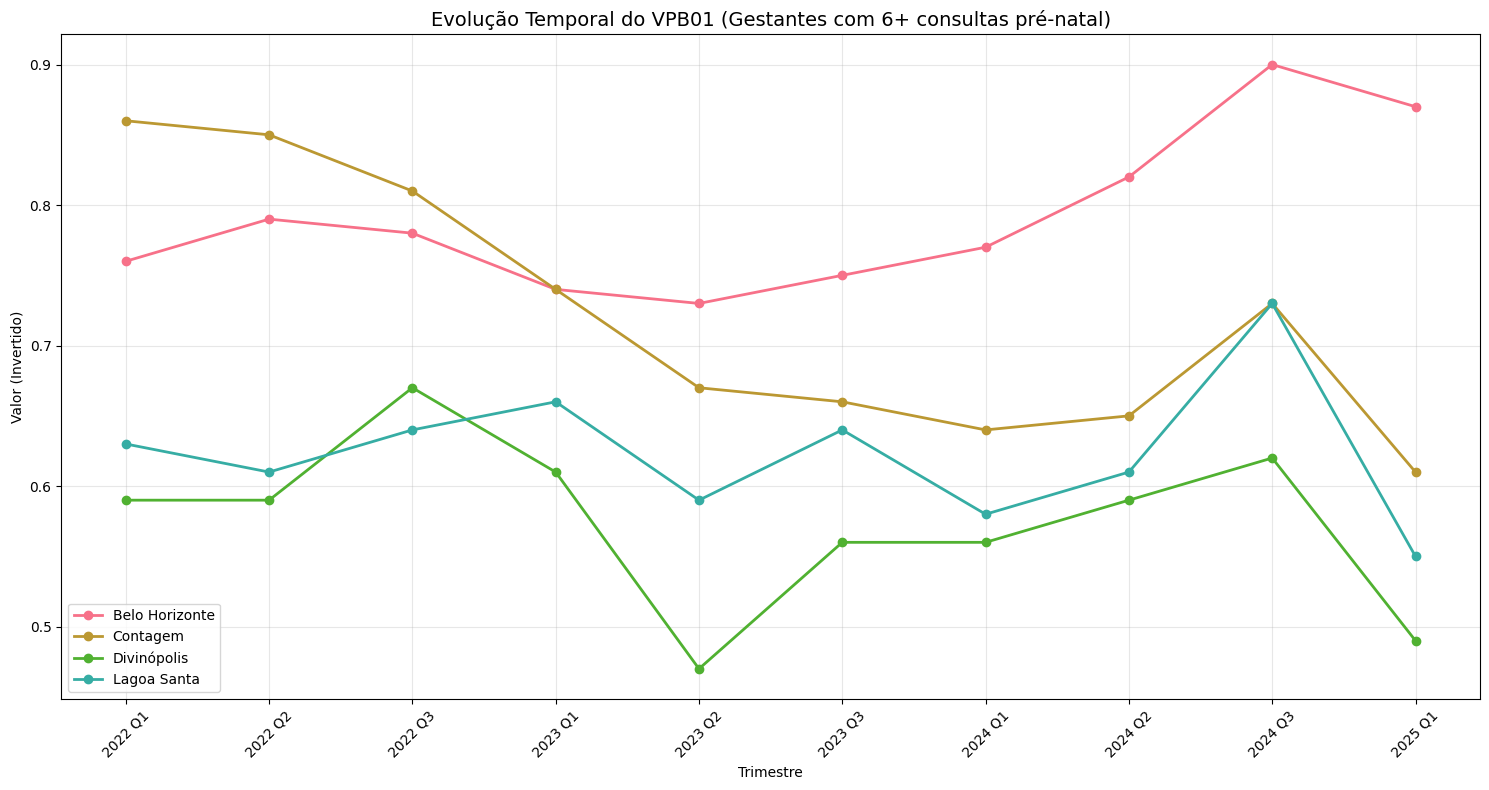

In [53]:
# Gráfico de evolução temporal para VPB01
plt.figure(figsize=(15, 8))

for municipio in df_temporal['MUNICIPIO'].unique():
    dados_municipio = df_temporal[df_temporal['MUNICIPIO'] == municipio]
    plt.plot(dados_municipio['TRIMESTRE'], dados_municipio['VALOR'], 
            marker='o', label=municipio, linewidth=2, markersize=6)

plt.title('Evolução Temporal do VPB01 (Gestantes com 6+ consultas pré-natal)', fontsize=14)
plt.xlabel('Trimestre')
plt.ylabel('Valor (Invertido)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


A evolução temporal do indicador VPB01 (Gestantes com 6+ consultas pré-natal) revela padrões distintos entre os municípios analisados. Os valores invertidos indicam que quanto maior o valor, maior a necessidade de atenção (menor cobertura). A análise permite identificar tendências de melhoria ou deterioração dos indicadores de saúde ao longo do tempo, fornecendo insights valiosos para o planejamento e previsão de demanda por serviços de APS.


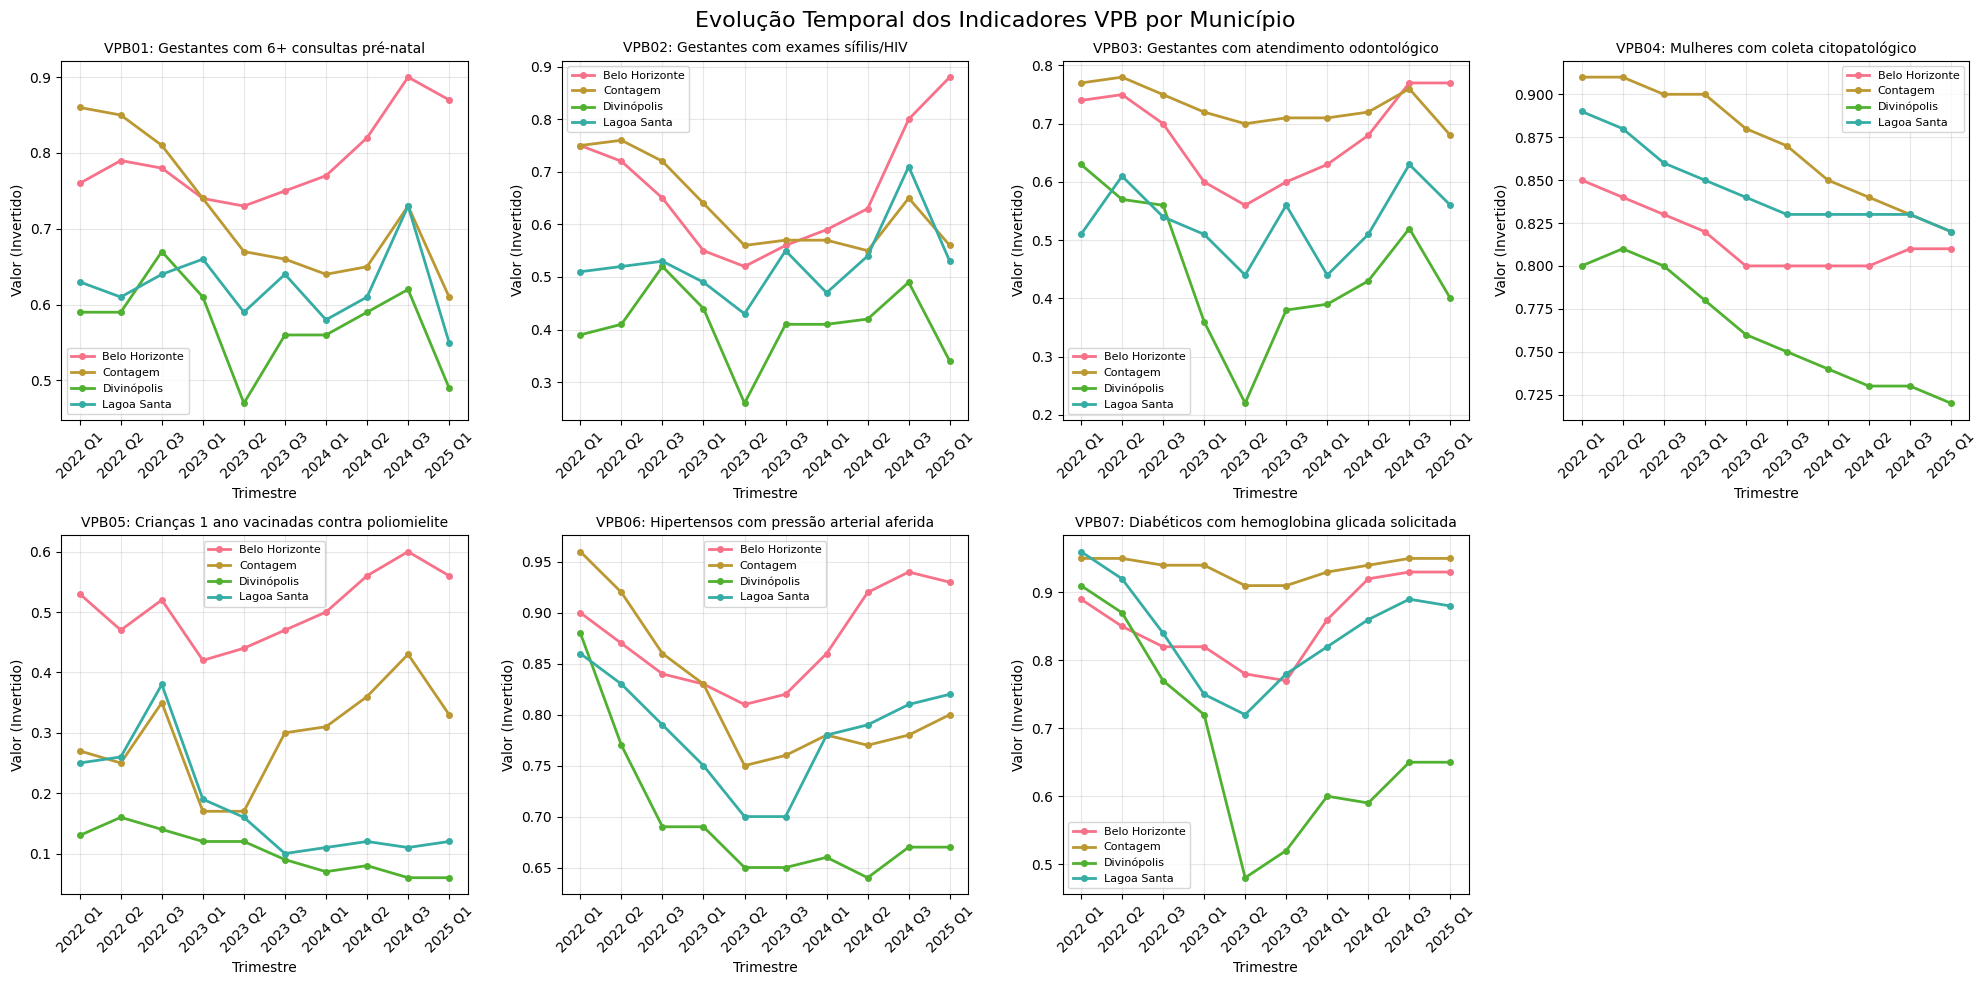

In [56]:
# Gráficos de evolução temporal para todos os indicadores VPB
indicadores_vpb = {
    'VPB01': 'Gestantes com 6+ consultas pré-natal',
    'VPB02': 'Gestantes com exames sífilis/HIV',
    'VPB03': 'Gestantes com atendimento odontológico',
    'VPB04': 'Mulheres com coleta citopatológico',
    'VPB05': 'Crianças 1 ano vacinadas contra poliomielite',
    'VPB06': 'Hipertensos com pressão arterial aferida',
    'VPB07': 'Diabéticos com hemoglobina glicada solicitada'
}

# Criar DataFrame temporal para todos os indicadores
dados_temporais_completo = []

for municipio in df_integrado['MUNICIPIO'].unique():
    if pd.isna(municipio):
        continue
        
    dados_municipio = df_integrado[df_integrado['MUNICIPIO'] == municipio]
    
    for vpb in indicadores_vpb.keys():
        for col in colunas_vpb:
            if vpb in col and dados_municipio[col].notna().any():
                # Extrair trimestre da coluna
                if '2022 Q1' in col:
                    trimestre = '2022 Q1'
                elif '2022 Q2' in col:
                    trimestre = '2022 Q2'
                elif '2022 Q3' in col:
                    trimestre = '2022 Q3'
                elif '2023 Q1' in col:
                    trimestre = '2023 Q1'
                elif '2023 Q2' in col:
                    trimestre = '2023 Q2'
                elif '2023 Q3' in col:
                    trimestre = '2023 Q3'
                elif '2024 Q1' in col:
                    trimestre = '2024 Q1'
                elif '2024 Q2' in col:
                    trimestre = '2024 Q2'
                elif '2024 Q3' in col:
                    trimestre = '2024 Q3'
                elif '2025 Q1' in col:
                    trimestre = '2025 Q1'
                else:
                    continue
                
                valor = dados_municipio[col].iloc[0]
                
                dados_temporais_completo.append({
                    'MUNICIPIO': municipio,
                    'INDICADOR': vpb,
                    'DESCRICAO': indicadores_vpb[vpb],
                    'TRIMESTRE': trimestre,
                    'VALOR': valor
                })

df_temporal_completo = pd.DataFrame(dados_temporais_completo)

# Criar gráficos individuais para cada indicador
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Evolução Temporal dos Indicadores VPB por Município', fontsize=16)

for i, (vpb, descricao) in enumerate(indicadores_vpb.items()):
    row = i // 4
    col = i % 4
    
    dados_indicador = df_temporal_completo[df_temporal_completo['INDICADOR'] == vpb]
    
    for municipio in dados_indicador['MUNICIPIO'].unique():
        dados_municipio = dados_indicador[dados_indicador['MUNICIPIO'] == municipio]
        axes[row, col].plot(dados_municipio['TRIMESTRE'], dados_municipio['VALOR'], 
                          marker='o', label=municipio, linewidth=2, markersize=4)
    
    axes[row, col].set_title(f'{vpb}: {descricao}', fontsize=10)
    axes[row, col].set_xlabel('Trimestre')
    axes[row, col].set_ylabel('Valor (Invertido)')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend(fontsize=8)

# Remover o último subplot vazio
axes[1, 3].remove()

plt.tight_layout()
plt.show()


A análise temporal dos indicadores VPB revela padrões distintos entre os municípios analisados. Divinópolis apresenta o melhor desempenho consistente na maioria dos indicadores, mantendo valores invertidos baixos e estáveis. Belo Horizonte e Contagem frequentemente apresentam os maiores desafios, Belo Horizonte inclusive com tendências de piora em indicadores críticos como gestantes com consultas pré-natal (VPB01) e exames sífilis/HIV (VPB02). Lagoa Santa exibe padrões intermediários com maior volatilidade. Esses padrões temporais são cruciais para entender a dinâmica da demanda por APS e informar estratégias de intervenção.


In [60]:
# Análise Espacial dos Indicadores - Versão Simplificada
import re

import folium


# Extrair coordenadas das strings
def extrair_coordenadas(coord_str):
    if pd.isna(coord_str):
        return None, None
    try:
        numeros = re.findall(r"-?\d+\.?\d*", str(coord_str))
        if len(numeros) >= 2:
            lat = float(numeros[0])
            lon = float(numeros[1])
            return lat, lon
    except:
        pass
    return None, None


# Aplicar extração de coordenadas
df_analise[["LATITUDE", "LONGITUDE"]] = df_analise["Coordenadas"].apply(
    lambda x: pd.Series(extrair_coordenadas(x))
)

# Filtrar apenas setores com coordenadas válidas
df_geo = df_analise.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()
print(f"Setores com coordenadas válidas: {len(df_geo)}")

# Verificar distribuição das coordenadas
print(f"Latitude: {df_geo['LATITUDE'].min():.4f} a {df_geo['LATITUDE'].max():.4f}")
print(f"Longitude: {df_geo['LONGITUDE'].min():.4f} a {df_geo['LONGITUDE'].max():.4f}")

# Criar mapa base
centro_lat = df_geo["LATITUDE"].mean()
centro_lon = df_geo["LONGITUDE"].mean()

# Mapa de vulnerabilidade em saúde
mapa = folium.Map(
    location=[centro_lat, centro_lon], zoom_start=11, tiles="OpenStreetMap"
)

# Adicionar pontos coloridos por vulnerabilidade
for idx, row in df_geo.iterrows():
    cor = (
        "red"
        if row["Vulnerab. Saúde"] > 0.7
        else "orange" if row["Vulnerab. Saúde"] > 0.5 else "green"
    )
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=2,
        popup=f"Setor: {row['SETOR']}<br>Vulnerabilidade: {row['Vulnerab. Saúde']:.3f}",
        color=cor,
        fill=True,
        fillOpacity=0.6,
    ).add_to(mapa)

# Salvar mapa
mapa.save("mapa_vulnerabilidade.html")
print("Mapa salvo como 'mapa_vulnerabilidade.html'")

# Mostrar estatísticas por município
print("\nEstatísticas por município:")
for municipio in df_geo["MUNICIPIO"].unique():
    dados_municipio = df_geo[df_geo["MUNICIPIO"] == municipio]
    print(f"{municipio}: {len(dados_municipio)} setores")
    print(f"  - Vulnerabilidade média: {dados_municipio['Vulnerab. Saúde'].mean():.3f}")
    print(f"  - Capital Humano médio: {dados_municipio['Capital Humano'].mean():.3f}")
    print(f"  - Índice médio: {dados_municipio['Índice'].mean():.3f}")
    print()


Setores com coordenadas válidas: 4803
Latitude: -20.2597 a -19.1354
Longitude: -51.4046 a -43.8327
Mapa salvo como 'mapa_vulnerabilidade.html'

Estatísticas por município:
Belo Horizonte: 3218 setores
  - Vulnerabilidade média: 0.813
  - Capital Humano médio: 0.188
  - Índice médio: 0.497

Contagem: 853 setores
  - Vulnerabilidade média: 0.768
  - Capital Humano médio: 0.181
  - Índice médio: 0.470

Divinópolis: 508 setores
  - Vulnerabilidade média: 0.552
  - Capital Humano médio: 0.180
  - Índice médio: 0.359

Lagoa Santa: 224 setores
  - Vulnerabilidade média: 0.658
  - Capital Humano médio: 0.175
  - Índice médio: 0.421

